In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as mtick

In [2]:
base_path = os.path.join(os.getcwd(), '..', 'steam-insights-main')

games_df_path = os.path.join(base_path, 'games.csv')
genres_path = os.path.join(base_path, 'genres.csv')
steamspy_insights_path = os.path.join(base_path, 'steamspy_insights.csv')
tags_path = os.path.join(base_path, 'tags.csv')

In [3]:
# Read games.csv (only app_id and name) and drop rows with missing name
games = pd.read_csv(
    games_df_path,
    usecols=["app_id", "name"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip'
)
games = games.dropna(subset=['name'])


# Read steamspy_insights.csv (only app_id, owners_range, and price)
steamspy = pd.read_csv(
    steamspy_insights_path,
    usecols=["app_id", "owners_range", "price"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)

# Immediately drop rows with missing values in 'owners_range' or 'price'
steamspy = steamspy.dropna(subset=['owners_range', 'price'])

# Replace 'N' in the 'price' column with NaN
steamspy['price'] = steamspy['price'].replace('N', np.nan)

# Convert price to numeric and handle any invalid entries as NaN
steamspy['price'] = pd.to_numeric(steamspy['price'], errors='coerce')

# Drop rows with NaN in 'price' after conversion
steamspy = steamspy.dropna(subset=['price'])

# Check for missing values in 'owners_range' and 'price'
missing_owners_range = steamspy['owners_range'].isna().sum()
missing_price = steamspy['price'].isna().sum()

print(f"Missing 'owners_range' values: {missing_owners_range}")
print(f"Missing 'price' values: {missing_price}")

# Adjust price (divide by 100 to get price in euros)
steamspy['price'] = steamspy['price'] / 100

# Check if there are any rows with price == 0
zero_price = steamspy[steamspy['price'] == 0]
print(f"Number of rows with price = 0: {len(zero_price)}")

# Optionally, drop rows with price == 0
steamspy = steamspy[steamspy['price'] != 0]

# Check if there are still any missing values in the 'price' column after filtering
missing_price_after_filtering = steamspy['price'].isna().sum()
print(f"There are {missing_price_after_filtering} missing values in the 'price' column after filtering.")



# Read tags.csv (only app_id and tag) and drop rows with missing tag
tags_df = pd.read_csv(
    tags_path,
    usecols=["app_id", "tag"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
tags_df = tags_df.dropna(subset=['tag'])

# Read genres.csv (only app_id and genre) and drop rows with missing genre
genres_df = pd.read_csv(
    genres_path,
    usecols=["app_id", "genre"],
    quotechar='"',
    doublequote=True,
    escapechar='\\',
    delimiter=',',
    engine='python',
    on_bad_lines='skip',
    na_values=["\\N"]
)
genres_df = genres_df.dropna(subset=['genre'])


# Group tags by app_id, joining multiple tags into one string
tags_grouped = tags_df.groupby("app_id")["tag"].apply(lambda x: ", ".join(x.astype(str))).reset_index()

# Group genres by app_id, joining multiple genres into one string
genres_grouped = genres_df.groupby("app_id")["genre"].apply(lambda x: ", ".join(x.astype(str))).reset_index()

Missing 'owners_range' values: 0
Missing 'price' values: 0
Number of rows with price = 0: 15333
There are 0 missing values in the 'price' column after filtering.


In [4]:
# Merge games and steamspy with an inner join so that only games present in both are kept
df_merged = pd.merge(games, steamspy, on="app_id", how="inner")

# Merge with grouped tags and genres (left join so that if a game lacks tags/genres, it still remains)
df_merged = pd.merge(df_merged, tags_grouped, on="app_id", how="left")
df_merged = pd.merge(df_merged, genres_grouped, on="app_id", how="left")

# Fill missing values in tag and genre with default values
df_merged['tag'] = df_merged['tag'].fillna('No Tags')
df_merged['genre'] = df_merged['genre'].fillna('No Genre')

display(df_merged.head())
print(f"Total rows in merged data: {df_merged.shape[0]}")

,app_id,name,owners_range,price,tag,genre
0,10,Counter-Strike,"10,000,000 .. 20,000,000",9.99,"1980s, 1990's, Action, Assassin, Classic, Comp...",Action
1,20,Team Fortress Classic,"5,000,000 .. 10,000,000",4.99,"1990's, Action, Class-Based, Classic, Co-op, C...",Action
2,30,Day of Defeat,"5,000,000 .. 10,000,000",4.99,"Action, Class-Based, Classic, Co-op, Difficult...",Action
3,40,Deathmatch Classic,"5,000,000 .. 10,000,000",4.99,"1990's, Action, Arena Shooter, Classic, Co-op,...",Action
4,50,Half-Life: Opposing Force,"2,000,000 .. 5,000,000",4.99,"1990's, Action, Adventure, Aliens, Atmospheric...",Action


Total rows in merged data: 75557


In [5]:
# Check for missing values (NaN) in the 'price' column
missing_price = df_merged['price'].isna().sum()

if missing_price > 0:
    print(f"There are {missing_price} missing values in the 'price' column.")
else:
    print("There are no missing values in the 'price' column.")




There are no missing values in the 'price' column.


In [6]:
rowsE = len(df_merged.axes[0])
columnsE = len(df_merged.axes[1])
print("df_merged:", rowsE, "rows and", columnsE, "columns")

df_merged: 75557 rows and 6 columns


In [7]:
print(len(tags_df['tag'].unique()))
print(len(genres_df['genre'].unique()))

447
121


In [8]:
print(df_merged['owners_range'].unique())
print(len(df_merged['owners_range'].unique()))
nan_rows = df_merged[(df_merged.owners_range.isnull())]
print(len(nan_rows))


['10,000,000 .. 20,000,000' '5,000,000 .. 10,000,000'
 '2,000,000 .. 5,000,000' '1,000,000 .. 2,000,000' '500,000 .. 1,000,000'
 '50,000,000 .. 100,000,000' '20,000 .. 50,000' '200,000 .. 500,000'
 '100,000 .. 200,000' '0 .. 20,000' '50,000 .. 100,000'
 '20,000,000 .. 50,000,000']
12
0


In [9]:
# Finds the average of the owners range, to plot on a graph
# The average is put into a new column called 'owners_avg'

def average_owners_range(range_str):
    if pd.isna(range_str):  # Handle NaN values
        return np.nan
    try:
        low, high = range_str.replace(",", "").split(" .. ")  # Remove commas and split
        return (int(low) + int(high)) / 2  # Compute the average
    except:
        return np.nan  # In case of any issues

df_merged['owners_avg'] = df_merged['owners_range'].apply(average_owners_range)

# Drop rows with NaN values in the 'owners_avg' column
df_merged = df_merged.dropna(subset=['owners_avg'])
df_merged['owners_avg'].isna().sum()
display(df_merged.head())


,app_id,name,owners_range,price,tag,genre,owners_avg
0,10,Counter-Strike,"10,000,000 .. 20,000,000",9.99,"1980s, 1990's, Action, Assassin, Classic, Comp...",Action,15000000.0
1,20,Team Fortress Classic,"5,000,000 .. 10,000,000",4.99,"1990's, Action, Class-Based, Classic, Co-op, C...",Action,7500000.0
2,30,Day of Defeat,"5,000,000 .. 10,000,000",4.99,"Action, Class-Based, Classic, Co-op, Difficult...",Action,7500000.0
3,40,Deathmatch Classic,"5,000,000 .. 10,000,000",4.99,"1990's, Action, Arena Shooter, Classic, Co-op,...",Action,7500000.0
4,50,Half-Life: Opposing Force,"2,000,000 .. 5,000,000",4.99,"1990's, Action, Adventure, Aliens, Atmospheric...",Action,3500000.0


In [10]:
# Shows the unique values of the owners_avg column and that there are no NaN values
print(df_merged['owners_avg'].unique())
print(len(df_merged['owners_avg'].unique()))
nan_rows = df_merged[(df_merged.owners_avg.isnull())]
print(len(nan_rows))

# Shows 6 rows removed
rowsE = len(df_merged.axes[0])
columnsE = len(df_merged.axes[1])
print("df_merged:", rowsE, "rows and", columnsE, "columns")

[1.5e+07 7.5e+06 3.5e+06 1.5e+06 7.5e+05 7.5e+07 3.5e+04 3.5e+05 1.5e+05
 1.0e+04 7.5e+04 3.5e+07]
12
0
df_merged: 75557 rows and 7 columns


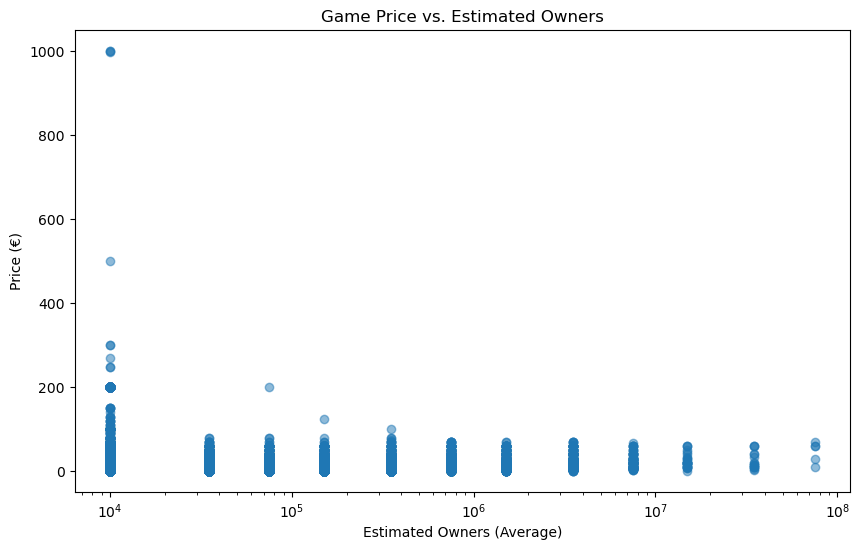

In [11]:
# Attempt to plot the data

plt.figure(figsize=(10, 6))
plt.scatter(df_merged['owners_avg'], df_merged['price'], alpha=0.5)
plt.xlabel("Estimated Owners (Average)")
plt.ylabel("Price (€)")
plt.title("Game Price vs. Estimated Owners")
plt.xscale("log")  # Log scale to better visualize large ranges
plt.show()


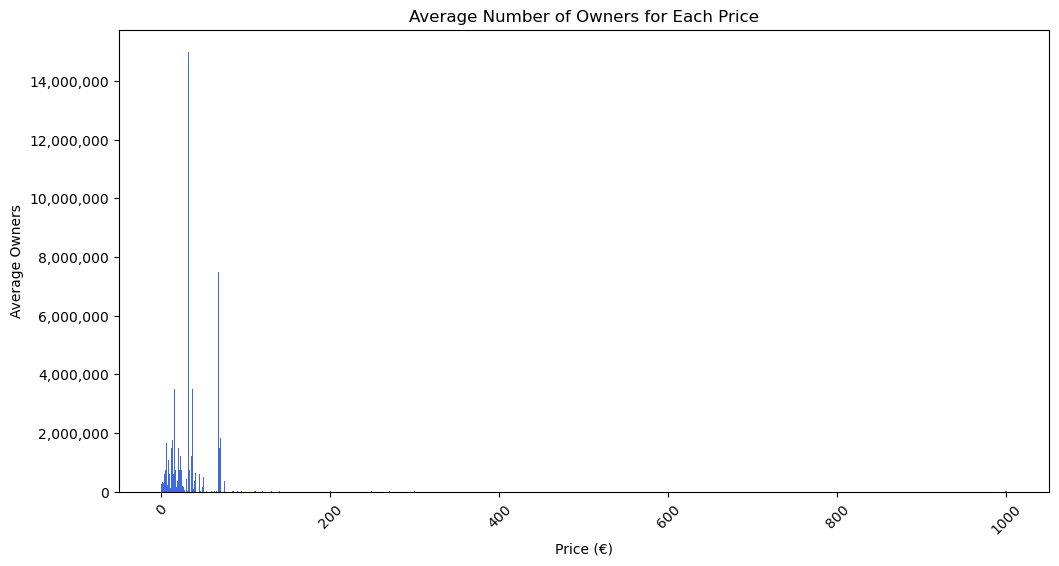

In [23]:

# Group by price and sum the owners_avg
price_owners = df_merged.groupby('price')['owners_avg'].mean().reset_index()

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(price_owners['price'], price_owners['owners_avg'], color='royalblue')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Add thousands separator

# Labels and title
plt.xlabel('Price (€)')
plt.ylabel('Average Owners')
plt.title('Average Number of Owners for Each Price')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

# Show the plot
plt.show()


In [24]:
# Find the most expensive games               
expensive = df_merged[(df_merged.price >500)]
display(expensive.head())

,app_id,name,owners_range,price,tag,genre,owners_avg,price_bin
30957,1200520,Ascent Free-Roaming VR Experience,"0 .. 20,000",999.00,"Action, Anime, Arena Shooter, Cute, Dating Sim...",Action,10000.0,NaN
64704,2499620,The Leverage Game,"0 .. 20,000",999.98,"2D, Board Game, Cute, Economy, Education, Hent...","Indie, Simulation",10000.0,NaN
64773,2504210,The Leverage Game Business Edition,"0 .. 20,000",999.98,"2D, Board Game, Casual, Cute, Economy, Educati...","Indie, Simulation",10000.0,NaN


/var/folders/7d/f5l9spks5w37wbgh6ljw23th0000gn/T/ipykernel_13636/2150999627.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_owners = df_merged.groupby('price_bin')['owners_avg'].mean().reset_index()


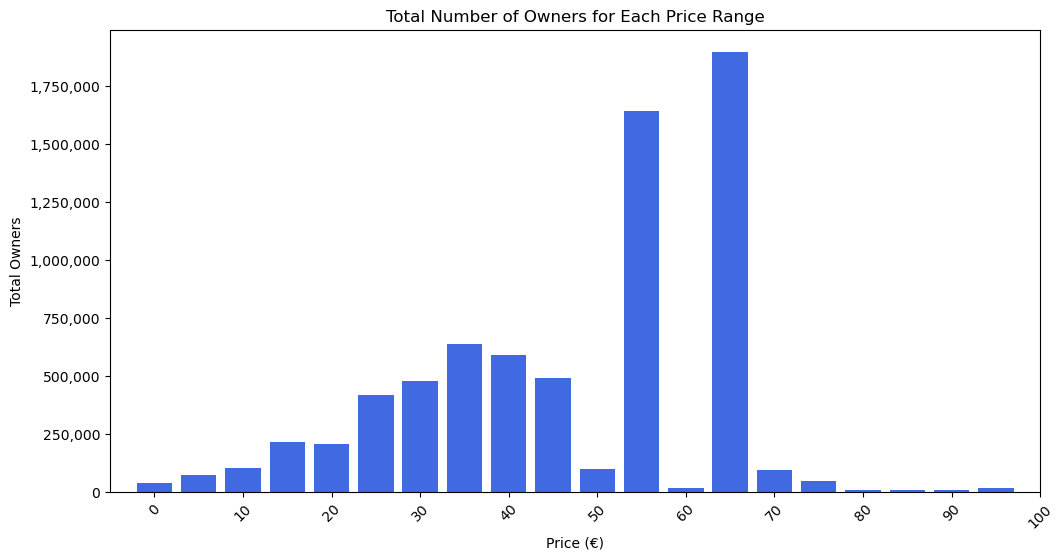

In [44]:

# Define price bins (0 to 100 in steps of 10)
bins = np.arange(0, 110, 5)  # Binning prices in intervals of 10€
df_merged['price_bin'] = pd.cut(df_merged['price'], bins, right=False)

# Group by price bin and sum the owners_avg
price_owners = df_merged.groupby('price_bin')['owners_avg'].mean().reset_index()

# Convert bins to string labels for x-axis
price_owners['price_bin'] = price_owners['price_bin'].astype(str)

# Plot the bar graph
plt.figure(figsize=(12, 6))
plt.bar(price_owners['price_bin'], price_owners['owners_avg'], color='royalblue')

# Limit x-axis to prices up to €100
plt.xlim(-1, len(bins) - 2)  # Adjust range to exclude bins beyond €100

# Format y-axis for readability (show full numbers)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Adds thousands separator

# Labels and title
plt.xlabel('Price (€)')
plt.ylabel('Total Owners')
plt.title('Total Number of Owners for Each Price Range')

# Reduce the number of x-axis ticks for readability
plt.xticks(ticks=np.arange(0, len(bins)-1, 2), labels=bins[:-1:2], rotation=45)  # Show every second tick

# Show the plot
plt.show()


Beta 0: 47043.54048348097, Beta 1: 5128.831577449959


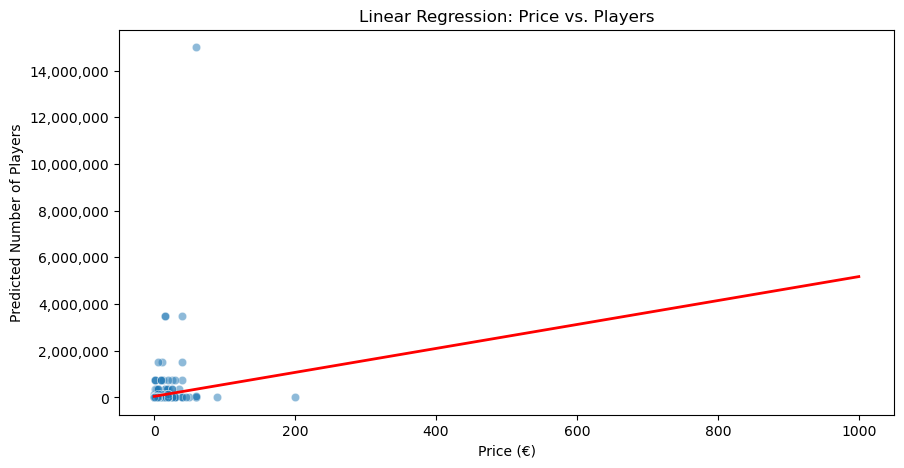

In [45]:
df_regression = df_merged[['price', 'owners_avg']].dropna()

# Define X (price) and y (owners_avg)
X = df_regression[['price']].to_numpy(copy=True)
y = df_regression['owners_avg'].to_numpy()

# Train Linear Regression Model
model = LinearRegression().fit(X, y)

# Get coefficients
beta0 = model.intercept_
beta1 = model.coef_[0]
print(f"Beta 0: {beta0}, Beta 1: {beta1}")

# Plot the regression line
plt.figure(figsize=(10, 5))
sns.scatterplot(x='price', y='owners_avg', data=df_regression.sample(500), alpha=0.5)  # Sample for better visualization

# Create regression line
x_range = np.linspace(df_regression.price.min(), df_regression.price.max(), 100)
plt.plot(x_range, model.predict(x_range.reshape(-1, 1)), color='red', linewidth=2)

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))  # Adds thousands separator
# Labels and title
plt.xlabel('Price (€)')
plt.ylabel('Predicted Number of Players')
plt.title('Linear Regression: Price vs. Players')

plt.show()

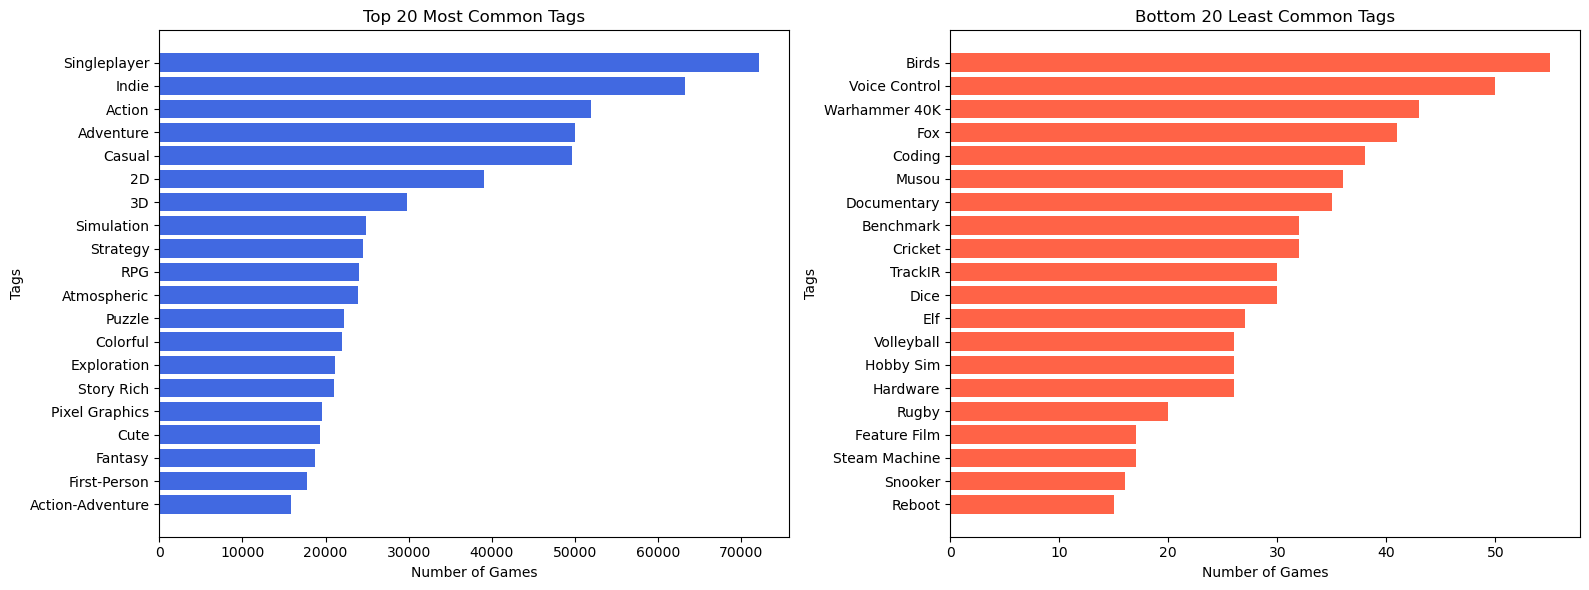

In [46]:
# Count number of games associated with each tag
tag_popularity = tags_df['tag'].value_counts().reset_index()
tag_popularity.columns = ['tag', 'game_count']

# Get the top 20 and bottom 20 tags based on game count
top_tags = tag_popularity.head(20)
bottom_tags = tag_popularity.tail(20)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Most Popular Tags
axes[0].barh(top_tags['tag'], top_tags['game_count'], color='royalblue')
axes[0].set_xlabel('Number of Games')
axes[0].set_ylabel('Tags')
axes[0].set_title('Top 20 Most Common Tags')
axes[0].invert_yaxis()

# Plot Least Popular Tags
axes[1].barh(bottom_tags['tag'], bottom_tags['game_count'], color='tomato')
axes[1].set_xlabel('Number of Games')
axes[1].set_ylabel('Tags')
axes[1].set_title('Bottom 20 Least Common Tags')
axes[1].invert_yaxis()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [47]:
missing_values = df_merged.isna().sum()
print(missing_values)

total_missing = df_merged.isna().sum().sum()
print(f"Total missing values: {total_missing}")



app_id            0
name              0
owners_range      0
price             0
tag               0
genre             0
owners_avg        0
price_bin       168
dtype: int64
Total missing values: 168


Intercept: -30002.703674163728
Coefficients: [ 2.90803582e+03  1.73511464e+04  9.95203147e+03 -1.16103634e+04
 -9.52055190e+03 -2.01723779e+04 -1.62123976e+04  1.46614305e+03
 -9.31472431e+04 -4.42226611e+04 -9.40094557e+03  5.78744674e+04
 -1.91893677e+04  1.10391115e+04 -4.20302186e+04 -8.27306665e+03
 -4.05767675e+04 -1.18662139e+04  3.62088971e+04  1.16104498e+04
 -5.74086449e+04 -2.10435359e+04 -6.90581352e+04  1.05127685e+04
  1.57380995e+04  4.25457751e+04  2.75966124e+04 -1.50910225e+04
  1.45824331e+04 -1.65938924e+04  4.14022579e+04 -1.30368664e+04
 -1.36416711e+04 -4.16050082e+04 -6.54870536e+04 -2.79874600e+04
  1.24575384e+05 -6.62268549e+04 -8.67255645e+04  5.90656882e+04
 -2.31855785e+04  2.54418394e+04  7.84339375e+04  3.02734262e+04
  1.62187811e+04 -8.75971734e+04 -8.83705148e+03  1.52854676e+05
  1.35643947e+03 -1.20184154e+05 -1.77665707e+04  4.62078498e+04
  1.82880914e+05 -7.52614578e+04 -4.26296788e+04 -3.94705263e+04
 -1.90381168e+04 -1.08755077e+05 -1.14232496e

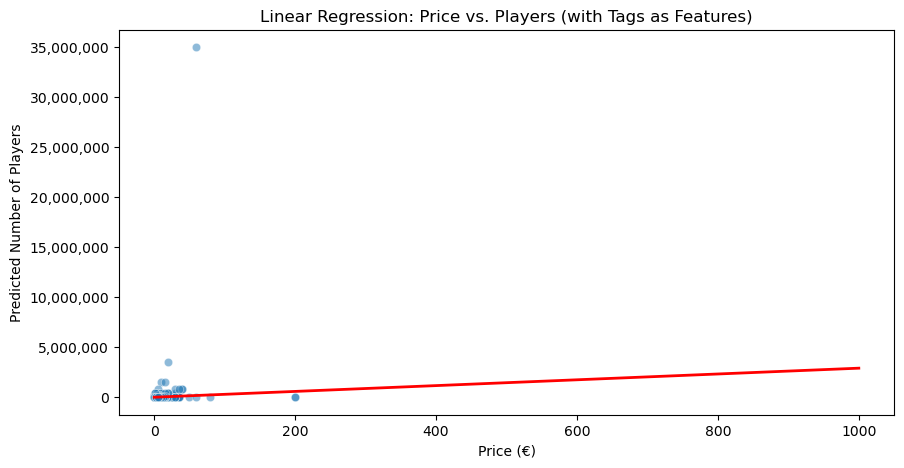

In [48]:

# One-hot encode the tags (adjust the separator if needed)
tags_dummies = df_merged['tag'].str.get_dummies(sep=", ")

# Combine price and the tag dummy variables to form your feature matrix
X = pd.concat([df_merged[['price']], tags_dummies], axis=1)

# Your target remains the estimated average owners
y = df_merged['owners_avg']

# Optionally, drop rows with missing target values
mask = y.notna()
X = X[mask]
y = y[mask]

# Train the Linear Regression model
model = LinearRegression().fit(X, y)

# Display model intercept and coefficients
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

# If you'd like to visualize the relationship between price and owners_avg:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='price', y='owners_avg', data=df_merged.sample(500), alpha=0.5)
x_range = np.linspace(df_merged.price.min(), df_merged.price.max(), 100)
plt.plot(x_range, model.predict(pd.concat([pd.DataFrame({'price': x_range}), 
                                             pd.DataFrame(np.zeros((100, tags_dummies.shape[1])), 
                                                          columns=tags_dummies.columns)], axis=1)), 
         color='red', linewidth=2)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.xlabel('Price (€)')
plt.ylabel('Predicted Number of Players')
plt.title('Linear Regression: Price vs. Players (with Tags as Features)')
plt.show()


In [49]:
# Find the row with the maximum value of owners_avg
max_owners_game = df_merged[df_merged['owners_avg'] == df_merged['owners_avg'].max()]

# Display the game details
print(max_owners_game[['app_id', 'name', 'owners_avg', 'price']])


        app_id                 name  owners_avg  price
19         550        Left 4 Dead 2  75000000.0   9.99
26536  1063730  New World: Aeternum  75000000.0  59.99
43467  1623730             Palworld  75000000.0  29.99
51935  1938090        Call of Duty®  75000000.0  69.99
61680  2358720   Black Myth: Wukong  75000000.0  59.99


In [ ]:
# IDEA
# use the owners range (from steamspy_insight.csv) and analyse how it relates to the game’s price.
# take tags/genres into consideration
# maybe then make a model that guesses how many players there will be based on the price and tags/genres



